# Дифракция Фраунгофера

In [38]:
import numpy as np
import matplotlib.pylab as plt
from scipy.special import jv


def wavefront_initialize(pixelsize_h=1e-6, pixelsize_v=1e-6, npixels_h=1024, npixels_v=1024, amplitude_value=0.0):
    amplitude = np.zeros((npixels_h, npixels_v))
    amplitude += amplitude_value
    p_i_h = np.arange(npixels_h) * pixelsize_h
    p_x = (p_i_h - 0.5 * (p_i_h[-1] - p_i_h[0]))
    p_i_v = np.arange(npixels_v) * pixelsize_v
    p_y = (p_i_v - 0.5 * (p_i_v[-1] - p_i_v[0]))
    return p_x, p_y, amplitude


def propagator2d_fraunhoffer(p_x, p_y, image, wavelength=1e-10):
    # преобразование Фурье
    F1 = np.fft.fft2(image)
    F2 = np.fft.fftshift(F1)

    # частота для оси 1
    pixelsize = p_x[1] - p_x[0]
    npixels = p_x.size
    freq_nyquist = 0.5 / pixelsize
    freq_n = np.linspace(-1.0, 1.0, npixels)
    freq_x = freq_n * freq_nyquist
    freq_x *= wavelength

    # частота для оси 2
    pixelsize = p_y[1] - p_y[0]
    npixels = p_y.size
    freq_nyquist = 0.5/pixelsize
    freq_n = np.linspace(-1.0, 1.0, npixels)
    freq_y = freq_n * freq_nyquist
    freq_y *= wavelength

    return freq_x, freq_y, F2


def plot_image(mymode, theta, psi, title="TITLE", xtitle=r"X [$\mu m$]", ytitle=r"Y [$\mu m$]", cmap=None):
    fig = plt.figure()

    plt.imshow(mymode.T, origin="lower", extent=[theta[0], theta[-1], psi[0], psi[-1]], cmap=cmap)
    plt.colorbar()
    ax = fig.gca()
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

    plt.title(title)
    plt.savefig(title + ".png")
    plt.show()


def line_image(image,horizontal_or_vertical="H"):
    if horizontal_or_vertical == "H":
        npixels = image.shape[0]
        tmp = image[:, image.shape[1] // 2]
    else:
        npixels = image.shape[1]
        tmp = image[image.shape[0] // 2, :]
    return tmp


def line_fwhm(line):
    tt = np.where(line>=max(line)*0.5)
    if line[tt].size > 1:
        FWHM = (tt[0][-1]-tt[0][0])
        return FWHM
    else:
        return -1


def plot(*positional_parameters, title="", xtitle="", ytitle="", legend=None, color=None):
    n_arguments = len(positional_parameters)
    if n_arguments == 0:
        return

    fig = plt.figure()

    if n_arguments == 1:
        y = positional_parameters[0]
        x = np.arange(y.size)
        plt.plot(x, y, label=legend)
    elif n_arguments == 2:
        x = positional_parameters[0]
        y = positional_parameters[1]
        plt.plot(x, y, label=legend,color=color)
    elif n_arguments == 4:
        x1 = positional_parameters[0]
        y1 = positional_parameters[1]
        x2 = positional_parameters[2]
        y2 = positional_parameters[3]
        if legend != None:
            legend1 = legend[0]
            legend2 = legend[1]
        else:
            legend1 = None
            legend2 = None
        if color != None:
            color1 = color[0]
            color2 = color[1]
        else:
            color1 = None
            color2 = None
        plt.plot(x1, y1, label=legend1,color=color1)
        plt.plot(x2, y2, label=legend2,color=color2)

    if legend != None:
        ax = plt.subplot(111)
        ax.legend(bbox_to_anchor=(1.1, 1.05))

    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.savefig(title + ".png")
    plt.show()

In [39]:
def circular_aperture(p_x, p_y, amplitude, radius=25e-6, type=0):
    p_xx = p_x[:, np.newaxis]
    p_yy = p_y[np.newaxis, :]

    filter = np.zeros_like(amplitude)
    filter_illuminated_indices = np.where(p_xx ** 2 + p_yy ** 2 < radius ** 2)
    if filter_illuminated_indices[0].size ==0:
        print("")
    else:
        filter[filter_illuminated_indices] = 1.0

    return p_x, p_y, amplitude * filter

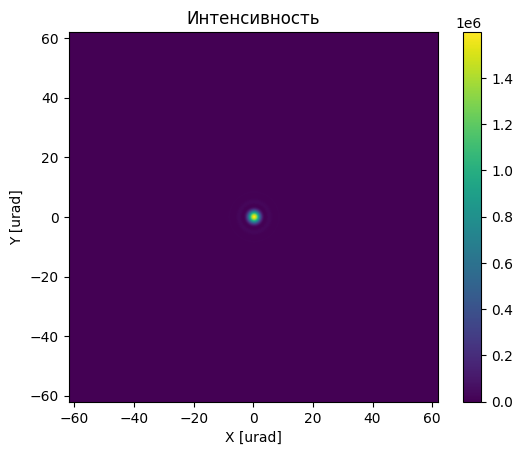

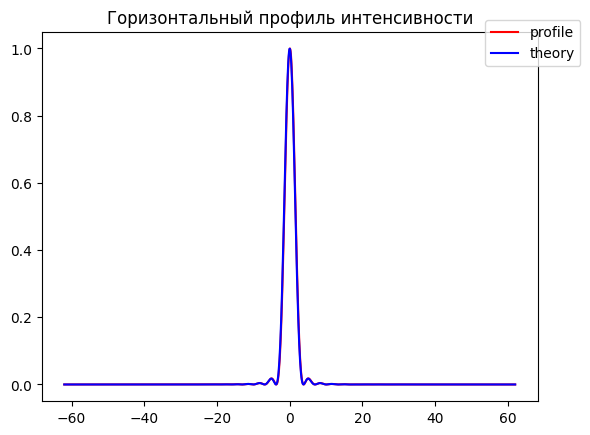

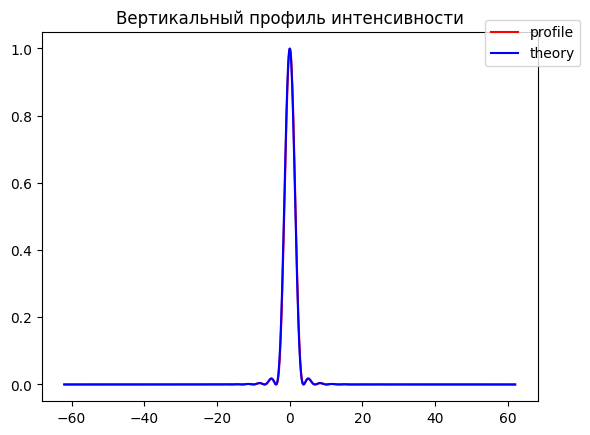

In [40]:
wavelength = 1.24e-10
aperture_radius = 20e-6
pixelsize_x = 1e-6
pixelsize_y = pixelsize_x
npixels_x = 1024
npixels_y = npixels_x
propagation_distance = 30.0

p_x, p_y, amplitude = wavefront_initialize(pixelsize_x, pixelsize_y, npixels_x, npixels_y, amplitude_value=1.0)
p_x, p_y, amplitude = circular_aperture(p_x, p_y, amplitude, radius=aperture_radius)

angle_x, angle_y, amplitude_propagated = propagator2d_fraunhoffer(p_x, p_y, amplitude, wavelength=wavelength)

plot_image(np.abs(amplitude_propagated)**2,angle_x*1e6,angle_y*1e6,title="Интенсивность",xtitle="X [urad]",ytitle="Y [urad]")

horizontal_intensity_profile = line_image(np.abs(amplitude_propagated)**2,horizontal_or_vertical='H')
horizontal_intensity_profile /= horizontal_intensity_profile.max()

vertical_intensity_profile = line_image(np.abs(amplitude_propagated)**2,horizontal_or_vertical='V')
vertical_intensity_profile /= vertical_intensity_profile.max()

x = (2*np.pi/wavelength) * (aperture_radius) * angle_x
y = (2*np.pi/wavelength) * (aperture_radius) * angle_y
U_vs_theta_x = 2*jv(1,x)/x
U_vs_theta_y = 2*jv(1,y)/y
I_vs_theta_x = U_vs_theta_x**2
I_vs_theta_y = U_vs_theta_y**2

fwhm_intensity_profile_horizontal = line_fwhm(horizontal_intensity_profile) * (angle_x[1]-angle_x[0])
fwhm_intensity_profile_vertical = line_fwhm(vertical_intensity_profile) * (angle_y[1]-angle_y[0])
fwhm_theoretical_profile_horizontal = line_fwhm(I_vs_theta_x) * (angle_x[1]-angle_x[0])
fwhm_theoretical_profile_vertical = line_fwhm(I_vs_theta_y) * (angle_y[1]-angle_y[0])

plot( angle_x*1e6, horizontal_intensity_profile, angle_x*1e6, I_vs_theta_x,
        legend=["profile","theory"],color=["red","blue"],
        title="Горизонтальный профиль интенсивности", xtitle='',ytitle='')
plot( angle_y*1e6, vertical_intensity_profile, angle_y*1e6, I_vs_theta_y,
        legend=["profile","theory"],color=["red","blue"],
        title="Вертикальный профиль интенсивности", xtitle='',ytitle='')

In [41]:
def square_aperture(p_x, p_y, amplitude, side=25e-6, type=0):
    p_xx = p_x[:, np.newaxis]
    p_yy = p_y[np.newaxis, :]

    filter = np.zeros_like(amplitude)
    filter_illuminated_indices = np.where( (np.abs(p_xx) < side) & (np.abs(p_yy) < side))
    filter[filter_illuminated_indices] = 1.0

    return p_x, p_y, amplitude * filter

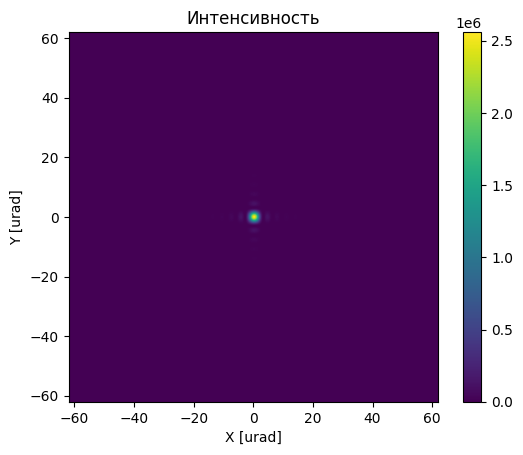

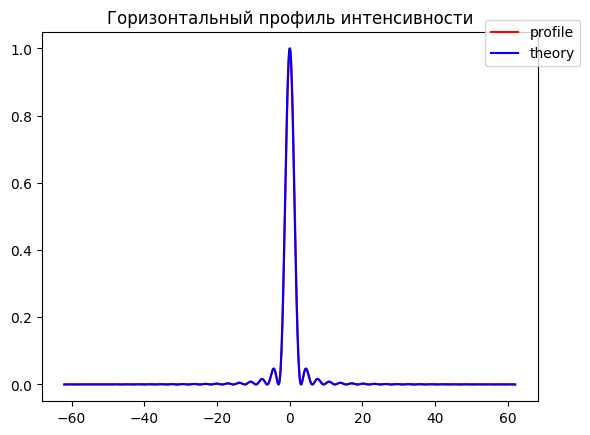

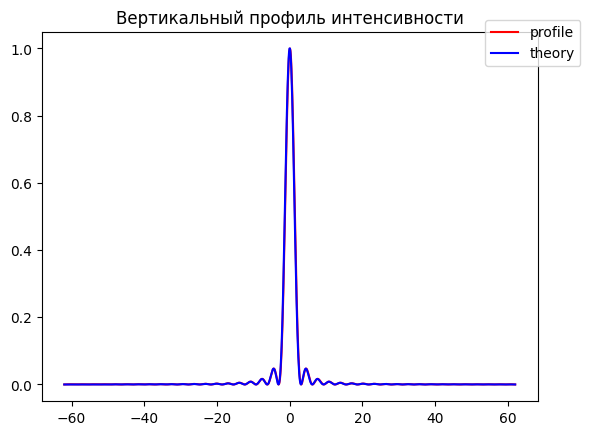

In [44]:
wavelength = 1.24e-10
aperture_radius = 20e-6
pixelsize_x = 1e-6
pixelsize_y = pixelsize_x
npixels_x = 1024
npixels_y = npixels_x
propagation_distance = 30.0

p_x, p_y, amplitude = wavefront_initialize(pixelsize_x, pixelsize_y, npixels_x, npixels_y, amplitude_value=1.0)
p_x, p_y, amplitude = square_aperture(p_x, p_y, amplitude, side=aperture_radius)

angle_x, angle_y, amplitude_propagated = propagator2d_fraunhoffer(p_x, p_y, amplitude, wavelength=wavelength)

plot_image(np.abs(amplitude_propagated)**2,angle_x*1e6,angle_y*1e6,title="Интенсивность",xtitle="X [urad]",ytitle="Y [urad]")

horizontal_intensity_profile = line_image(np.abs(amplitude_propagated)**2,horizontal_or_vertical='H')
horizontal_intensity_profile /= horizontal_intensity_profile.max()

vertical_intensity_profile = line_image(np.abs(amplitude_propagated)**2,horizontal_or_vertical='V')
vertical_intensity_profile /= vertical_intensity_profile.max()

x = (2*np.pi/wavelength) * aperture_radius* angle_x
y = (2*np.pi/wavelength) * aperture_radius* angle_y
U_vs_theta_x = 2*np.sin(x)/x
U_vs_theta_y = 2*np.sin(y)/y
I_vs_theta_x = U_vs_theta_x**2
I_vs_theta_y = U_vs_theta_y**2
I_vs_theta_x /= I_vs_theta_x.max()
I_vs_theta_y /= I_vs_theta_y.max()

fwhm_intensity_profile_horizontal = line_fwhm(horizontal_intensity_profile) * (angle_x[1]-angle_x[0])
fwhm_intensity_profile_vertical = line_fwhm(vertical_intensity_profile) * (angle_y[1]-angle_y[0])
fwhm_theoretical_profile_horizontal = line_fwhm(I_vs_theta_x) * (angle_x[1]-angle_x[0])
fwhm_theoretical_profile_vertical = line_fwhm(I_vs_theta_y) * (angle_y[1]-angle_y[0])

plot( angle_x*1e6, horizontal_intensity_profile, angle_x*1e6, I_vs_theta_x,
        legend=["profile","theory"],color=["red","blue"],
        title="Горизонтальный профиль интенсивности", xtitle='',ytitle='')
plot( angle_y*1e6, vertical_intensity_profile, angle_y*1e6, I_vs_theta_y,
        legend=["profile","theory"],color=["red","blue"],
        title="Вертикальный профиль интенсивности", xtitle='',ytitle='')